# Importing Necessary Libraries

In [2]:
from dtaidistance.subsequence.dtw import subsequence_alignment, subsequence_search
from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
from tslearn.metrics import dtw_path

from IPython import display
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

from scipy.stats import ttest_ind, combine_pvalues

import time
import warnings
warnings.filterwarnings('ignore')

from functions import *
import random
random.seed(0)


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

In [6]:
this_phrase = 'gmD'
this_raga = 'Bag'

In [7]:
# Columns to be included in the processing
cols = ['time','pitch','filename',
        'LWrist_x','LWrist_y','LWrist_z',
        'RWrist_x','RWrist_y','RWrist_z',
        'RWrist_vel_x','RWrist_vel_y','RWrist_vel_z',
        'LWrist_vel_x','LWrist_vel_y','LWrist_vel_z',
        'RWrist_vel_3d','LWrist_vel_3d',
        'RWrist_accl_x','RWrist_accl_y','RWrist_accl_z',
        'LWrist_accl_x','LWrist_accl_y','LWrist_accl_z',
        'RWrist_accl_3d','LWrist_accl_3d',
        'LElbow_x','LElbow_y','LElbow_z',
        'RElbow_x','RElbow_y','RElbow_z', 
        'LElbow_vel_x','LElbow_vel_y','LElbow_vel_z',
        'RElbow_vel_x','RElbow_vel_y','RElbow_vel_z', 
        'LElbow_accl_x','LElbow_accl_y','LElbow_accl_z',
        'RElbow_accl_x','RElbow_accl_y','RElbow_accl_z']

# Reading and Plotting Query Templates

In [10]:
phrase_df = pd.read_csv('./gmD_queries_chosen.csv')

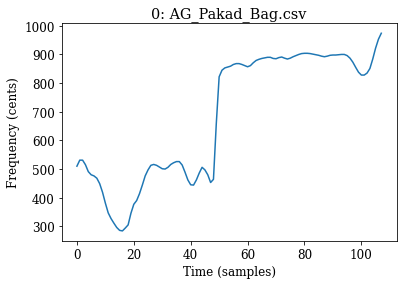

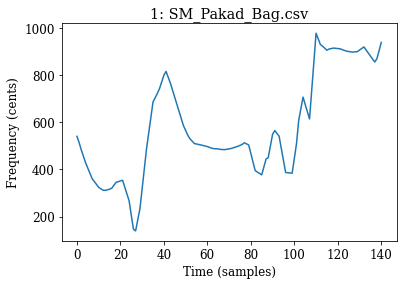

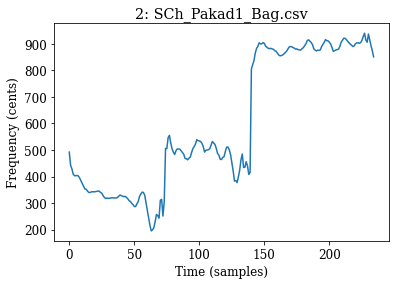

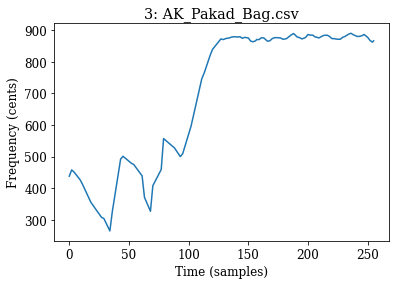

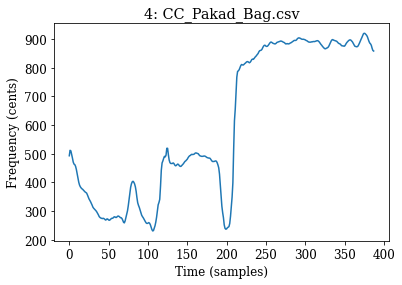

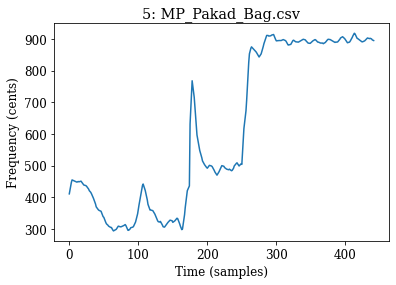

In [12]:
original_list = []

for i,row in phrase_df.iterrows():
    
    query = pd.read_csv(f'./gmD_Queries/{this_phrase}_query_{row.Index}.csv')
    plt.plot(np.array(query['pitch']))
    plt.ylabel('Frequency (cents)')
    plt.xlabel('Time (samples)')
    plt.title(str(i)+": " +row['Filename'])
    plt.show()
    original_list.append(np.array(query['pitch']))

# Warping Queries to Median Length

In [15]:
phrase2 = original_list[2] #target_index

warped_list = []

for phrase1 in original_list:
    kwargs = {'window':100,'max_step':None, 'penalty':200, 'max_dist':None}
    result = dtw_operation(series = phrase1, target = phrase2, plot_series = False, plot_path = False, **kwargs)
    warped_list.append(result)

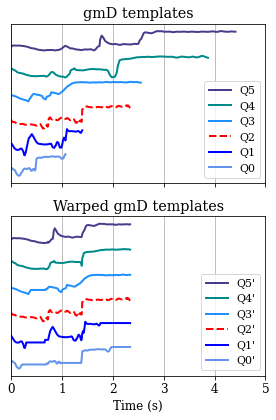

In [26]:
#Plot the query templates for comparing shape

colors = ['cornflowerblue','blue', 'red', 'dodgerblue', 'darkcyan', 'darkslateblue']
styles = ['-','-','--','-','-','-']

fig, (axis1, axis2) = plt.subplots(2,1,figsize = (4,6),sharex = True)
for i,contour in enumerate(original_list):
    axis1.plot(np.array(contour) + 800*i, label = f'Q{i}',linewidth = 2, 
               color = colors[i], linestyle = styles[i])
    axis2.plot(np.array(warped_list[i]) + 800*i, label = f"Q{i}'", linewidth = 2,
               color = colors[i], linestyle = styles[i])

    
font1 = {'family':'serif','color':'black','size':15}
font2 = {'family':'serif','color':'black','size':12}

handles1, labels1 = axis1.get_legend_handles_labels()
axis1.legend(handles1[::-1],labels1[::-1],loc=4, fontsize = 11)
axis1.set_xticks(axis1.get_xticks(),labels = (axis1.get_xticks()/100).astype(int))
axis1.set_xlim(0,350)
axis1.set_yticks([])
# axis1.set_ylabel('F0 (cents above tonic)')
axis1.set_title(f'{this_phrase} templates')
axis1.grid()

handles2, labels2 = axis2.get_legend_handles_labels()
axis2.legend(handles2[::-1],labels2[::-1],loc=4,fontsize = 11)
axis2.set_xticks(axis2.get_xticks(),labels = (axis2.get_xticks()//100).astype(int))
axis2.set_xlabel('Time (s)')
# axis2.set_ylabel('F0 (cents above tonic)')
axis2.set_title(f'Warped {this_phrase} templates')
axis2.set_xlim(0,500)
axis2.set_yticks([])
axis2.grid()

plt.tight_layout()
plt.savefig('gmD_templates.png', format = 'png', facecolor = 'white')
plt.show();

# Alap processing beings here

In [27]:
this_raga_master = pd.DataFrame([])

for singer in ['AG','AK','AP','CC','MG','MP','NM','RV','SCh','SM','SS']:
    
    master = pd.read_csv(f'./../../Data/check_output_Jan20/check_output_v2/{singer}_gesture_pitch_pd_with_vel_accln.csv',
                         usecols=cols)
    master = master.loc[master['filename'].apply(lambda x: x.split('_')[2][:-4] == this_raga)]
    this_raga_master = pd.concat([this_raga_master, master])
    print(singer)

AG
AK
AP
CC
MG
MP
NM
RV
SCh
SM
SS


In [28]:
aalaps = this_raga_master.loc[this_raga_master['filename'].apply(lambda x: 'Aalap' in x)]
aalaps

,LElbow_x,LElbow_y,LElbow_z,RElbow_x,RElbow_y,RElbow_z,LWrist_x,LWrist_y,LWrist_z,RWrist_x,...,LWrist_accl_y,LWrist_accl_z,LElbow_accl_x,LElbow_accl_y,LElbow_accl_z,RElbow_accl_x,RElbow_accl_y,RElbow_accl_z,RWrist_accl_3d,LWrist_accl_3d
0,0.124163,0.168752,0.223823,1.117963,-0.184325,1.944848,1.960998,2.325453,1.122182,-0.961094,...,1.720240,-4.772793,-0.271947,1.129339,-0.217320,-0.307233,-0.515608,-2.625323,3.098629,5.163736
1,0.217895,0.016827,0.394638,1.128789,-0.009204,2.414284,2.265465,2.361650,1.560179,-1.282341,...,1.818363,-4.963407,-0.259194,1.318931,-0.232270,-0.299187,-0.510703,-2.742044,3.183886,5.375106
2,0.237173,-0.012450,0.410091,1.112745,0.070003,2.477170,2.313882,2.359027,1.657446,-1.312333,...,1.915551,-5.143467,-0.242215,1.521562,-0.249497,-0.287477,-0.502436,-2.856152,3.257703,5.575687
3,0.203661,0.042978,0.315794,1.079211,0.076721,2.251395,2.180955,2.329499,1.508652,-1.137283,...,2.011107,-5.311474,-0.220759,1.736436,-0.269377,-0.271869,-0.490881,-2.967190,3.319114,5.763855
4,0.151931,0.124006,0.184780,1.042086,0.050415,1.926824,1.985702,2.291663,1.269531,-0.894424,...,2.104311,-5.466029,-0.194610,1.962537,-0.292301,-0.252153,-0.476185,-3.074753,3.367278,5.938087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173927,-1.878033,-0.206349,0.370546,-1.233590,0.192781,-0.126944,-0.976119,-0.826247,-0.000851,0.232839,...,1.910688,-0.725410,3.996662,-3.418417,1.474083,-1.683534,-2.297478,1.155915,2.362119,2.556246
173928,-1.881870,-0.235642,0.382557,-1.229367,0.167490,-0.123607,-0.971052,-0.831026,0.000478,0.240454,...,1.843223,-0.801444,3.784190,-3.401859,1.355433,-1.631154,-2.168575,1.011960,2.225974,2.481055
173929,-1.887010,-0.264605,0.395708,-1.227143,0.137568,-0.117165,-0.965312,-0.836922,0.004560,0.247341,...,1.772300,-0.864048,3.572394,-3.364925,1.241777,-1.573937,-2.038693,0.877745,2.093832,2.403881
173930,-1.891352,-0.296426,0.407417,-1.227796,0.104574,-0.110195,-0.959607,-0.843906,0.009565,0.253546,...,1.698468,-0.913675,3.362354,-3.309269,1.133382,-1.512579,-1.908871,0.753468,1.965822,2.324287


In [29]:
# Standard Scaler for SVM training
X = aalaps.drop(columns = ['time','pitch','filename']).reset_index(drop=True)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X[['time','pitch','filename']] = aalaps[['time','pitch','filename']].reset_index(drop=True)
aalaps = X.copy()
aalaps

,LElbow_x,LElbow_y,LElbow_z,RElbow_x,RElbow_y,RElbow_z,LWrist_x,LWrist_y,LWrist_z,RWrist_x,...,LElbow_accl_y,LElbow_accl_z,RElbow_accl_x,RElbow_accl_y,RElbow_accl_z,RWrist_accl_3d,LWrist_accl_3d,time,pitch,filename
0,0.108179,0.201843,0.155728,1.154875,-0.142358,2.003239,2.061467,2.528089,1.133234,-1.018500,...,0.086232,-0.031178,-0.032917,-0.045900,-0.409396,-0.677308,-0.471667,0.00,-3000.0,AG_Aalap1_Bag.csv
1,0.204090,0.049294,0.339934,1.165722,0.034402,2.497644,2.375025,2.566092,1.589848,-1.351139,...,0.100567,-0.033334,-0.032043,-0.045468,-0.427569,-0.667974,-0.449602,0.01,-3000.0,AG_Aalap1_Bag.csv
2,0.223817,0.019897,0.356598,1.149646,0.114349,2.563875,2.424887,2.563337,1.691250,-1.382194,...,0.115888,-0.035819,-0.030771,-0.044739,-0.445335,-0.659892,-0.428662,0.02,-3000.0,AG_Aalap1_Bag.csv
3,0.189525,0.075553,0.254908,1.116048,0.121129,2.326091,2.287991,2.532336,1.536132,-1.200937,...,0.132134,-0.038687,-0.029076,-0.043721,-0.462624,-0.653168,-0.409018,0.03,-3000.0,AG_Aalap1_Bag.csv
4,0.136592,0.156914,0.113623,1.078851,0.094578,1.984257,2.086908,2.492612,1.286846,-0.949466,...,0.149229,-0.041994,-0.026935,-0.042425,-0.479371,-0.647894,-0.390830,0.04,-3000.0,AG_Aalap1_Bag.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398473,-1.940579,-0.174799,0.313953,-1.201213,0.238276,-0.178750,-0.963354,-0.780885,-0.037534,0.217771,...,-0.257621,0.212805,-0.182373,-0.202968,0.179328,-0.757947,-0.743874,194.44,-3000.0,SS_Aalap2_Bag.csv
398474,-1.944505,-0.204213,0.326905,-1.196983,0.212748,-0.175235,-0.958135,-0.785902,-0.036149,0.225656,...,-0.256369,0.195690,-0.176685,-0.191605,0.156915,-0.772853,-0.751724,194.45,-3000.0,SS_Aalap2_Bag.csv
398475,-1.949765,-0.233295,0.341088,-1.194754,0.182546,-0.168451,-0.952224,-0.792093,-0.031893,0.232787,...,-0.253576,0.179296,-0.170472,-0.180157,0.136018,-0.787321,-0.759780,194.46,-3000.0,SS_Aalap2_Bag.csv
398476,-1.954208,-0.265247,0.353715,-1.195408,0.149243,-0.161110,-0.946348,-0.799425,-0.026675,0.239213,...,-0.249368,0.163660,-0.163809,-0.168713,0.116669,-0.801337,-0.768089,194.47,-3000.0,SS_Aalap2_Bag.csv


In [30]:
filelist = aalaps['filename'].unique()
filelist

array(['AG_Aalap1_Bag.csv', 'AG_Aalap2_Bag.csv', 'AK_Aalap1_Bag.csv',
       'AK_Aalap2_Bag.csv', 'AP_Aalap1_Bag.csv', 'AP_Aalap2_Bag.csv',
       'CC_Aalap1_Bag.csv', 'CC_Aalap2_Bag.csv', 'MG_Aalap1_Bag.csv',
       'MG_Aalap2_Bag.csv', 'MP_Aalap1_Bag.csv', 'MP_Aalap2_Bag.csv',
       'NM_Aalap1_Bag.csv', 'NM_Aalap2_Bag.csv', 'RV_Aalap1_Bag.csv',
       'RV_Aalap2_Bag.csv', 'SCh_Aalap1_Bag.csv', 'SCh_Aalap2_Bag.csv',
       'SM_Aalap1_Bag.csv', 'SM_Aalap2_Bag.csv', 'SS_Aalap1_Bag.csv',
       'SS_Aalap2_Bag.csv'], dtype=object)

# Getting a dataframe of SDS information

In [31]:
sds_list = []

for filename in filelist:
    
    this_aalap = aalaps.loc[aalaps['filename']==filename].reset_index(drop=True)
    ipcdf = this_aalap[['time','pitch']] # ipcdf = Interpolated Pitch Contour DataFrame
    ipcdf, segments = split_into_segments(ipcdf) # function to generate SDS from alaps based on silence
    for i,x in enumerate(segments):
        sds_list.append((filename, x[0], x[1], i))

In [32]:
sds_df = pd.DataFrame(sds_list, columns = ['Filename','Start','End','SDS'])
sds_df

,Filename,Start,End,SDS
0,AG_Aalap1_Bag.csv,2.80,7.94,0
1,AG_Aalap1_Bag.csv,8.58,20.01,1
2,AG_Aalap1_Bag.csv,20.51,29.98,2
3,AG_Aalap1_Bag.csv,30.68,38.22,3
4,AG_Aalap1_Bag.csv,38.87,41.88,4
...,...,...,...,...
484,SS_Aalap2_Bag.csv,152.73,161.72,25
485,SS_Aalap2_Bag.csv,162.30,178.69,26
486,SS_Aalap2_Bag.csv,179.30,183.81,27
487,SS_Aalap2_Bag.csv,184.21,189.45,28


# DTW Subsequence Search

In [33]:
def get_pair_df(sds, warped_list, sds_id):
    '''
    Input:
    - sds: dataframe containing sds contours, mainly time and pitch
    - warped_list: list of warped query template dataframes
    Output: 
    a dataframe for this SDS, with 6 rows, one for each query. It
    contains cost and timestamps (if valid duration)
    '''
    segment_df = [] 
    filename = sds['filename'].iloc[0]
    for query_idx,query in enumerate(warped_list):

        sa = SubsequenceAlignment(query, np.array(sds['pitch']),
                                  penalty=0.1,use_c = True)

        for kmatch in sa.kbest_matches_fast(20):
            start_idx, end_idx = kmatch.segment[0], kmatch.segment[1]
            start_sec = np.array(sds['time'])[start_idx]
            end_sec = np.array(sds['time'])[end_idx]
            cost = round(kmatch.value,2)
            segment_df.append((filename, start_sec, end_sec,
                               sds_id, query_idx,cost))
    pair_df = []
    if segment_df == []:
        print(f"Note! Match not found for Aalap file {sds['filename'].iloc[0]},SDS id: {sds_id}")
    else:
        segment_df = pd.DataFrame(segment_df, 
                                  columns = ['Filename','Start','End','SDS',
                                             'Query','Cost'])
        segment_df['Duration'] = segment_df['End'] - segment_df['Start']
        valid_df = segment_df.loc[segment_df['Duration'] > 0.5]
        
        for query_idx,query in enumerate(warped_list):
            valid_costs_this_pair = list(valid_df.loc[valid_df['Query']==query_idx]['Cost']) 
            #list of costs for this SDS-query pair whose lengths are > 0.5
            if valid_costs_this_pair == []:
                continue
            else:
                pair_cost = min(valid_costs_this_pair)
                pair_start = valid_df.loc[valid_df['Cost']==pair_cost]['Start'].iloc[0]
                pair_end = valid_df.loc[valid_df['Cost']==pair_cost]['End'].iloc[0]
                pair_df_row = (filename, pair_start,pair_end,
                               sds_id,query_idx,pair_cost,pair_end - pair_start)
            pair_df.append(pair_df_row)
    pair_df = pd.DataFrame(pair_df, columns = ['Filename','Start','End',
                                               'SDS','Query','Cost','Duration']) 
    return pair_df

In [34]:
# segment_df is "df1", pair_df is "df2".
# We use the terms "df3" and "df4" to denote dataframes involving aggregation of the former
df3 = pd.DataFrame([], columns = ['Filename','Start','End','SDS',
                               'Query','Cost','Duration'])
df4 = []

start_time = time.time()

for i,row in sds_df.iterrows():
        
    aalap = aalaps.loc[aalaps['filename']==row['Filename']]
    sds = aalap.loc[aalap['time'].apply(lambda x: x >= row['Start'] and \
                                        x <= row['End'])]
    sds_id = row['SDS']
    pair_df = get_pair_df(sds,warped_list, sds_id)
    df3 = pd.concat([df3,pair_df],axis=0).reset_index(drop=True)
    
    if len(pair_df) > 0:
        pair_df = pair_df.sort_values(by='Cost').reset_index(drop=True)
        queries = pair_df.loc[0,'Query']
        costs = pair_df.loc[0,'Cost']
        df4.append(pair_df.iloc[0].values)

In [35]:
df4 = pd.DataFrame(df4, columns = df3.columns.values)

# Plotting Distribution of DTW Cost and Getting KDE

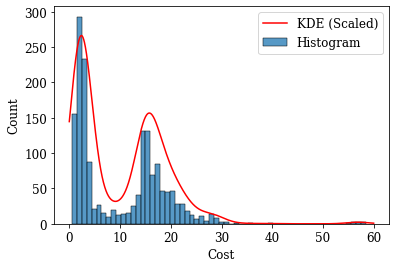

In [22]:
from scipy.stats import gaussian_kde

kernel = gaussian_kde(df3['Cost'].apply(float))
factor = 0.01
positions = np.arange(0,60,factor)
plt.plot(positions, kernel(positions)*3e3, color = 'red')
sns.histplot(df3['Cost'], bins = 60)
plt.legend(['KDE (Scaled)','Histogram']);

In [23]:
from scipy.signal import find_peaks

peaks = find_peaks(-kernel(positions))
peaks

(array([ 910, 3818, 4750]), {})

In [24]:
threshold = peaks[0][0] * factor
threshold

9.1

In [40]:
df4['Label'] = df4['Cost'].apply(lambda x: 'Like' if x<=0.5*threshold else 'Unlike')

In [42]:
df3['Label'] = df3['SDS'].apply(lambda x: df4.loc[df4['SDS']==x]['Label'].iloc[0])

In [43]:
df3.to_csv(f'./{this_phrase}_df3.csv',index=False)
df4.to_csv(f'./{this_phrase}_df4.csv', index=False)

# Gesture Processing Starts Here

In [17]:
df3 = pd.read_csv(f'{this_phrase}_df3.csv')
df4 = pd.read_csv(f'{this_phrase}_df4.csv')
query_loc = f'./Query_Templates/{this_phrase}_query_masterfiles/'

# df3 and df4 together constitute the "ground truth" for Like/Unlike prediction

In [45]:
df4

,Filename,Start,End,SDS,Query,Cost,Duration,Label
0,AG_Aalap1_Bag.csv,3.26,5.30,0,4,14.54,2.04,Unlike
1,AG_Aalap1_Bag.csv,8.93,9.60,1,3,1.27,0.67,Like
2,AG_Aalap1_Bag.csv,21.10,21.67,2,4,1.79,0.57,Like
3,AG_Aalap1_Bag.csv,47.17,48.06,6,0,24.33,0.89,Unlike
4,AG_Aalap1_Bag.csv,53.69,56.97,7,4,14.45,3.28,Unlike
...,...,...,...,...,...,...,...,...
326,SS_Aalap2_Bag.csv,159.30,160.08,25,0,2.75,0.78,Like
327,SS_Aalap2_Bag.csv,177.90,178.52,26,3,19.07,0.62,Unlike
328,SS_Aalap2_Bag.csv,179.55,181.24,27,5,0.80,1.69,Like
329,SS_Aalap2_Bag.csv,184.28,184.85,28,0,2.67,0.57,Like


In [53]:
gcols = ['LWrist_x','LWrist_y','LWrist_z',
         'RWrist_x','RWrist_y','RWrist_z',
         'LWrist_vel_x','LWrist_vel_y','LWrist_vel_z',
         'RWrist_vel_x','RWrist_vel_y','RWrist_vel_z',
         'LWrist_accl_x','LWrist_accl_y','LWrist_accl_z',
         'RWrist_accl_x','RWrist_accl_y','RWrist_accl_z',
         'LElbow_x','LElbow_y','LElbow_z',
         'RElbow_x','RElbow_y','RElbow_z',
         'LElbow_vel_x','LElbow_vel_y','LElbow_vel_z',
         'RElbow_vel_x','RElbow_vel_y','RElbow_vel_z',
         'LElbow_accl_x','LElbow_accl_y','LElbow_accl_z',
         'RElbow_accl_x','RElbow_accl_y','RElbow_accl_z']

In [33]:
def get_dtw_ind_cost(query, reference, gcols, sc_radius = 100):
    '''
    Carry out DTW-Ind operation on the two time series
    Inputs:
    - query: Query template gestures (pd.DataFrame)
    - reference: Timestamped SDS gestures from alap (pd.DataFrame)
    - gcols: Gesture columns to be included (list)
    - sc_radius: Sakoe-Chiba radius for constrained DTW (in samples)
    Output:
    - path_list: DTW optimal paths for each column (list)
    - cost_vector: Vector of DTW-Ind costs
    '''
    cost_vector = []
    path_list = []
    for j in range(len(gcols)):
        path, cost = dtw_path(query[gcols[j]], reference[gcols[j]], 
                              global_constraint= 'sakoe_chiba',
                              sakoe_chiba_radius=sc_radius)
        cost_vector.append(cost)
        path_list.append(path)
    return path_list, cost_vector

def get_dtw_i_cost(query1, reference1, gcols, sc_radius = 100):
    '''
    Carry out DTW-Ind operation on the two time series
    Inputs:
    - query: Query template gestures (pd.DataFrame)
    - reference: Timestamped SDS gestures from alap (pd.DataFrame)
    - gcols: Gesture columns to be included (list)
    - sc_radius: Sakoe-Chiba radius for constrained DTW (in samples)
    Output:
    - path_list: DTW optimal paths for each column (list)
    - total_cost: DTW-I cost (float)
    '''
    path_list = []
    total_cost = 0
    for j in range(len(gcols)):
        path, cost1 = dtw_path(query1[gcols[j]], reference1[gcols[j]], 
                              global_constraint= 'sakoe_chiba',
                              sakoe_chiba_radius=sc_radius)
        total_cost += cost1
        path_list.append(path)
    return path_list, total_cost

def get_dtw_LR_cost(query, reference, gcols, sc_radius = 100):
    '''
    Carry out DTW-LR operation on the two time series
    Inputs:
    - query: Query template gestures (pd.DataFrame)
    - reference: Timestamped SDS gestures from alap (pd.DataFrame)
    - gcols: Gesture columns to be included (list)
    - sc_radius: Sakoe-Chiba radius for constrained DTW (in samples)
    Output:
    - path_list: DTW optimal paths for each column (list)
    - cost_vector: Vector of DTW-LR costs
    '''
    cost_vector = []
    path_list = []
    lcols = [x for x in gcols if 'LWrist' in x]
    rcols = [x for x in gcols if 'RWrist' in x]
    
    lpath, lcost = dtw_path(query[lcols], reference[lcols],
                            global_constraint= 'sakoe_chiba',
                            sakoe_chiba_radius=sc_radius)
    cost_vector.append(lcost)
    path_list.append(lpath)
    
    rpath, rcost = dtw_path(query[rcols], reference[rcols],
                            global_constraint= 'sakoe_chiba',
                            sakoe_chiba_radius=sc_radius)
    cost_vector.append(rcost)
    path_list.append(rpath)

    return path_list, cost_vector

In [34]:
singer = 'NM'

singer_queries = phrase_df_all.loc[phrase_df_all['Filename'].apply(lambda x: x.split('_')[0]==singer)]
singer_queries.index.values

array([8])

# Carrying out DTW on Gestures

In [35]:
gesture_dict = {}

for singer in ['AG','AK','AP','CC','MG','MP','NM','RV','SCh','SM','SS']:
    
    print('Singer:', singer)
    
    df4_singer = df4.loc[df4['Filename'].apply(lambda x: x.split('_')[0]==singer)].reset_index(drop=True)
    df4_singer_like = df4_singer.loc[df4_singer['Label']=='Like']   

    SC_RADIUS = 100
    
    singer_queries= phrase_df_all.loc[phrase_df_all['Filename'].apply(lambda x:x.split('_')[0]==singer)]
    print('Query Indices:', singer_queries.index.values )
        
    for query_index in singer_queries.index.values:

        query = pd.read_csv(query_loc + f'{this_phrase}_query_{query_index}.csv')
        query = query[gcols].reset_index(drop=True)

        for i, row in df4_singer.iterrows():

            aalap = aalaps.loc[aalaps['filename']==row['Filename']]
            reference = aalap.loc[aalap['time'].apply(lambda x: x >= row['Start'] and x <= row['End'])]
            reference = reference[gcols].reset_index(drop=True)
            
            #For DTW-D we can directy use the dtw_path function,
            # For other DTW variants, we use the functions written by us above
            dtw_d_path, dtw_d_cost = dtw_path(query, reference, 
                              global_constraint= 'sakoe_chiba',
                              sakoe_chiba_radius=SC_RADIUS)

            dtw_i_path, dtw_i_cost = get_dtw_i_cost(query, reference, gcols, SC_RADIUS)
            dtw_ind_path, dtw_ind_cost = get_dtw_ind_cost(query, reference, gcols, SC_RADIUS)
            dtw_LR_path, dtw_LR_cost = get_dtw_LR_cost(query, reference, gcols, SC_RADIUS)
            dtw_PVA_path, dtw_PVA_cost = get_dtw_PVA_cost(query, reference, gcols, SC_RADIUS)

            row_dict = {'query_index':query_index, 'query':query, 'reference':reference, 
                        'dtw_d_path':dtw_d_path,'dtw_d_cost':dtw_d_cost, 
                        'dtw_i_path':dtw_i_path, 'dtw_i_cost':dtw_i_cost,
                        'dtw_ind_path':dtw_ind_path, 'dtw_ind_cost':dtw_ind_cost,
                        'dtw_LR_path':dtw_LR_path, 'dtw_LR_cost':dtw_LR_cost,
                        'dtw_PVA_path':dtw_PVA_path, 'dtw_PVA_cost':dtw_PVA_cost}

            gesture_dict[(query_index,i)] = row_dict

Singer: AG
Query Indices: [0]
Singer: AK
Query Indices: [1 2]
Singer: AP
Query Indices: [3]
Singer: CC
Query Indices: [4 5]
Singer: MG
Query Indices: [6]
Singer: MP
Query Indices: [7]
Singer: NM
Query Indices: [8]
Singer: RV
Query Indices: [9]
Singer: SCh
Query Indices: [10]
Singer: SM
Query Indices: [11 12]
Singer: SS
Query Indices: [13]


In [36]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

from statsmodels.stats.contingency_tables import mcnemar

In [37]:
def find_stat_signif(all_test, all_pred1, all_pred2):
    '''
    Mcnemar Test to Find Statistical Significance of Results
    '''
    clf1 = (np.concatenate(all_pred1) == np.concatenate(all_test))
    clf2 = (np.concatenate(all_pred2) == np.concatenate(all_test))

    yes_yes = sum((clf1) & (clf2))
    yes_no = sum(clf1 & (1-clf2))
    no_yes = sum((1-clf1) & clf2)
    no_no = sum((1-clf1) & (1-clf2))

    table =[[yes_yes, yes_no], [no_yes, no_no]]
    print('Contingency table:', table)

    mcnemar_result = mcnemar(table)
    print('P-value:', round(mcnemar_result.pvalue, 5))
    
    return round(mcnemar_result.pvalue, 5)

# Logistic Regression and Cross Validation

AG
Chance F1: 0.6


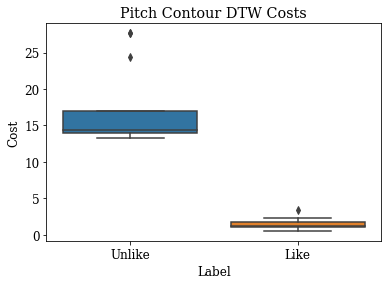

Query Indices: [0]

DTW-D
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ..............

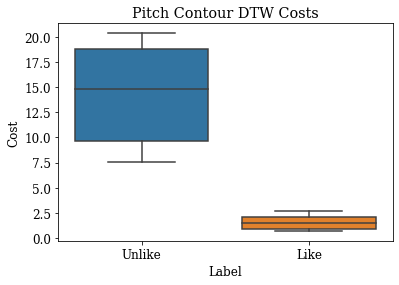

Query Indices: [1 2]

DTW-D
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ............

[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
Best index: 0
Best parameter

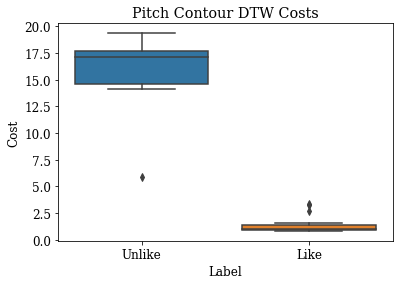

Query Indices: [3]

DTW-D
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ..............

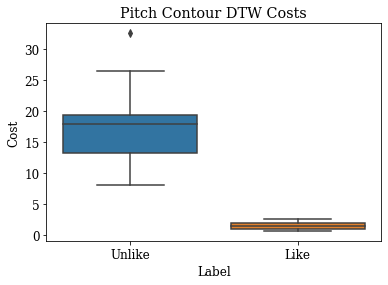

Query Indices: [4 5]

DTW-D
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ............

[CV] END ..................................C=100, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
Best index: 0
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best score: 0.5873015873015873
Contingency table: [[21, 6], [2, 6]]
P-value: 0.28906

DTW-Ind
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty

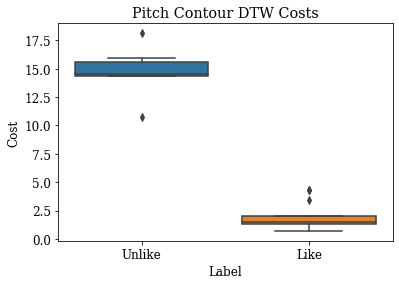

Query Indices: [6]

DTW-D
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ..............

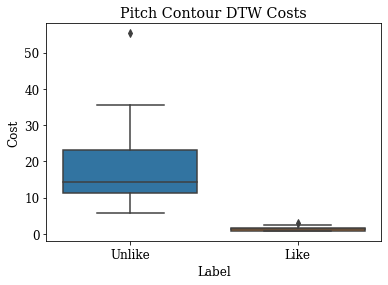

Query Indices: [7]

DTW-D
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ..............

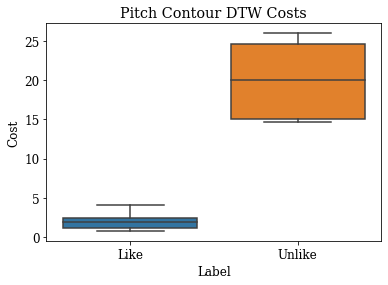

Query Indices: [8]

DTW-D
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ..............

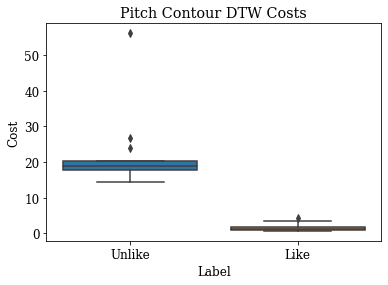

Query Indices: [9]

DTW-D
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ..............

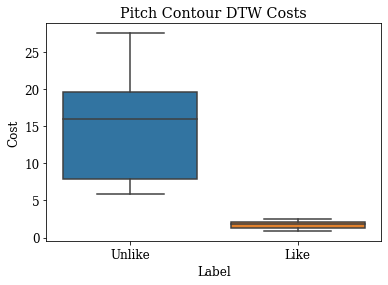

Query Indices: [10]

DTW-D
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END .............

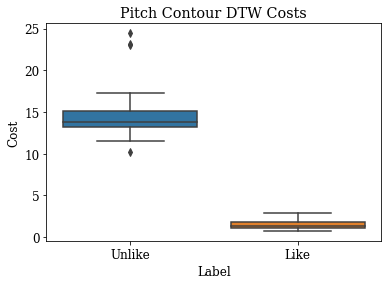

Query Indices: [11 12]

DTW-D
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ..........

[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
[CV] END ..................................C=100, penalty=l2; total time=   0.0s
Best index: 0
Best parameter

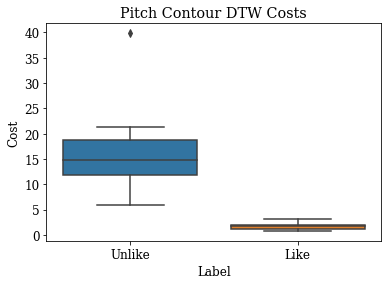

Query Indices: [13]

DTW-D
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END .............

In [38]:
all_test_dict = {}
all_pred_dict = {}
grid_objects = {}
summary = []

for singer in ['AG','AK','AP','CC','MG','MP','NM','RV','SCh','SM','SS']:
# for singer in ['CC']:
    
    print(singer)
    df4_singer = df4.loc[df4['Filename'].apply(lambda x: x.split('_')[0]==singer)].reset_index(drop=True)
    n1 = df4_singer['Label'].value_counts()['Like']
    n0 = len(df4_singer.loc[df4_singer['Label']=='Unlike'])
    if n1==0 or n0==0:
        continue
    print('Chance F1:',round(n1/(n1+n0), 2))
    statistic, p_value = ttest_ind(df4_singer.loc[df4_singer['Label']=='Like']['Cost'],
                               df4_singer.loc[df4_singer['Label']=='Unlike']['Cost'])
#     print(p_value)
    sns.boxplot(x = 'Label', y = 'Cost', data = df4_singer)
    plt.title('Pitch Contour DTW Costs');
    plt.show()
    
    singer_queries= phrase_df_all.loc[phrase_df_all['Filename'].apply(lambda x:x.split('_')[0]==singer)]
    print('Query Indices:', singer_queries.index.values)
        
    for query_index in singer_queries.index.values:
        
        this_query_results = [query_index, singer,
                              n1,n0,
                              round(n1/(n1+n0),4)]
        
        dtw_d = pd.DataFrame([], columns = ['DTW_D','Label'])
        dtw_i = pd.DataFrame([], columns = ['DTW_I','Label'])
        dtw_ind = pd.DataFrame([], columns = gcols + ['Label'])
        dtw_LR = pd.DataFrame([], columns = ['L','R','Label'])
        dtw_PVA = pd.DataFrame([], columns = ['P','V','A','Label'])

        for i, row in df4_singer.iterrows():
            cost_vector = gesture_dict[(query_index,i)]['dtw_ind_cost'] + [row['Label']]
            lr_vector = gesture_dict[(query_index,i)]['dtw_LR_cost'] + [row['Label']]
            pva_vector = gesture_dict[(query_index,i)]['dtw_PVA_cost'] + [row['Label']]
            dtw_d.loc[len(dtw_d.index)] = [gesture_dict[(query_index,i)]['dtw_d_cost'],row['Label']]
            dtw_i.loc[len(dtw_i.index)] = [gesture_dict[(query_index,i)]['dtw_i_cost'],row['Label']]
            dtw_ind.loc[len(dtw_ind.index)] = cost_vector
            dtw_LR.loc[len(dtw_LR.index)] = lr_vector
            dtw_PVA.loc[len(dtw_PVA.index)] = pva_vector
        
        X_d = dtw_d.iloc[:,0:1]    
        X_i = dtw_i.iloc[:,0:1]
        X_ind = dtw_ind.iloc[:,0:len(gcols)]
        X_LR = dtw_LR.iloc[:,0:2]
        X_PVA = dtw_PVA.iloc[:,0:3]
        y = dtw_i.iloc[:,-1].apply(lambda x: int(x == 'Like'))
        
        vc = y.value_counts()
        
        
        
        print('\nDTW-D')
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)
        
        params_grid = {'penalty': ['l2'],'C':[0.01,0.1,1,10,100]}
        scoring = {"Accuracy": make_scorer(accuracy_score),
               "f1": make_scorer(f1_score, average='binary', pos_label = 1)}
        grid = GridSearchCV(LogisticRegression(), params_grid,verbose=2,cv=kf, 
                        scoring = scoring, refit = 'f1')
        grid.fit(X_d, y)
        
        sample_indices_by_split = []
        for train_index, test_index in grid.cv.split(X_d,y):
            sample_indices_by_split.append((train_index, test_index))

        best_model=grid.best_estimator_

        print('Best index:', grid.best_index_)
        print('Best parameters:', grid.best_params_)
        print('Best score:', grid.best_score_)

        all_test = []
        all_pred = []
        results = []
        for i in range(3):
            train_indices=sample_indices_by_split[i][0]
            test_indices=sample_indices_by_split[i][1]
            X_train = X_d.iloc[train_indices,:].values
            y_train = y.iloc[train_indices].values
            X_test = X_d.iloc[test_indices].values
            y_test = y.iloc[test_indices].values
            best_model = grid.best_estimator_
            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_test)
            results.append([i,round(accuracy_score(y_test, y_pred), 4)
                                        ,round(f1_score(y_test, y_pred, average='binary',pos_label=1),4)])
            all_test.append(y_test)
            all_pred.append(y_pred)



        results = pd.DataFrame(results, columns = ['Split number','Accuracy','F1 Score'])

        all_pred_dict[singer] = all_pred
        all_test_dict[singer] = all_test
        grid_objects[singer] = grid

        r = vc[1]/(vc[1]+vc[0])
        np.random.seed(0)
        chance_pred = []
        for split_pred in all_pred:
            chance_pred.append(np.random.choice([1,0],size=len(split_pred),p=[r,1-r]))
        p_value = find_stat_signif(all_test, all_pred, chance_pred)
        
        summary.append([singer, vc.loc[0],vc.loc[1],
                        round(results['Accuracy'].mean(),3), 
                        round(results['F1 Score'].mean(),3), p_value, 'DTW-D'])
        
        ####################################################################
        print('\nDTW-I')
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)
        
        params_grid = {'penalty': ['l2'],'C':[0.01,0.1,1,10,100]}
        scoring = {"Accuracy": make_scorer(accuracy_score),
               "f1": make_scorer(f1_score, average='binary', pos_label = 1)}
        grid = GridSearchCV(LogisticRegression(), params_grid,verbose=2,cv=kf, 
                        scoring = scoring, refit = 'f1')
        grid.fit(X_i, y)
        
        sample_indices_by_split = []
        for train_index, test_index in grid.cv.split(X_i,y):
            sample_indices_by_split.append((train_index, test_index))

        best_model=grid.best_estimator_

        print('Best index:', grid.best_index_)
        print('Best parameters:', grid.best_params_)
        print('Best score:', grid.best_score_)

        all_test = []
        all_pred = []
        results = []
        for i in range(3):
            train_indices=sample_indices_by_split[i][0]
            test_indices=sample_indices_by_split[i][1]
            X_train = X_i.iloc[train_indices,:].values
            y_train = y.iloc[train_indices].values
            X_test = X_i.iloc[test_indices].values
            y_test = y.iloc[test_indices].values
            best_model = grid.best_estimator_
            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_test)
            results.append([i,round(accuracy_score(y_test, y_pred), 4)
                                        ,round(f1_score(y_test, y_pred, average='binary',pos_label=1),4)])
            all_test.append(y_test)
            all_pred.append(y_pred)



        results = pd.DataFrame(results, columns = ['Split number','Accuracy','F1 Score'])

        all_pred_dict[singer] = all_pred
        all_test_dict[singer] = all_test
        grid_objects[singer] = grid

        r = vc[1]/(vc[1]+vc[0])
        np.random.seed(0)
        chance_pred = []
        for split_pred in all_pred:
            chance_pred.append(np.random.choice([1,0],size=len(split_pred),p=[r,1-r]))
        p_value = find_stat_signif(all_test, all_pred, chance_pred)
        
        summary.append([singer, vc.loc[0],vc.loc[1],
                        round(results['Accuracy'].mean(),3), 
                        round(results['F1 Score'].mean(),3), p_value, 'DTW-I'])
        
        ####################################################################
        print('\nDTW-Ind')
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)
        
        params_grid = {'penalty': ['l2'],'C':[0.01,0.1,1,10,100]}
        scoring = {"Accuracy": make_scorer(accuracy_score),
               "f1": make_scorer(f1_score, average='binary', pos_label = 1)}
        grid = GridSearchCV(LogisticRegression(), params_grid,verbose=2,cv=kf, 
                        scoring = scoring, refit = 'f1')
        grid.fit(X_ind, y)
        
        sample_indices_by_split = []
        for train_index, test_index in grid.cv.split(X_ind,y):
            sample_indices_by_split.append((train_index, test_index))

        best_model=grid.best_estimator_

        print('Best index:', grid.best_index_)
        print('Best parameters:', grid.best_params_)
        print('Best score:', grid.best_score_)

        all_test = []
        all_pred = []
        results = []
        for i in range(3):
            train_indices=sample_indices_by_split[i][0]
            test_indices=sample_indices_by_split[i][1]
            X_train = X_ind.iloc[train_indices,:].values
            y_train = y.iloc[train_indices].values
            X_test = X_ind.iloc[test_indices].values
            y_test = y.iloc[test_indices].values
            best_model = grid.best_estimator_
            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_test)
            results.append([i,round(accuracy_score(y_test, y_pred), 4)
                                        ,round(f1_score(y_test, y_pred, average='binary',pos_label=1),4)])
            all_test.append(y_test)
            all_pred.append(y_pred)

        results = pd.DataFrame(results, columns = ['Split number','Accuracy','F1 Score'])

        all_pred_dict[singer] = all_pred
        all_test_dict[singer] = all_test
        grid_objects[singer] = grid

        r = vc[1]/(vc[1]+vc[0])
        np.random.seed(0)
        chance_pred = []
        for split_pred in all_pred:
            chance_pred.append(np.random.choice([1,0],size=len(split_pred),p=[r,1-r]))
        p_value = find_stat_signif(all_test, all_pred, chance_pred)
        
        summary.append([singer, vc.loc[0],vc.loc[1],
                        round(results['Accuracy'].mean(),3), 
                        round(results['F1 Score'].mean(),3), p_value, 'DTW-Ind'])
        
    ###############################################################################
    
        print('\nDTW-LR')
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)

        params_grid = {'penalty': ['l2'],'C':[0.01,0.1,1,10,100]}
        scoring = {"Accuracy": make_scorer(accuracy_score),
               "f1": make_scorer(f1_score, average='binary', pos_label = 1)}
        grid = GridSearchCV(LogisticRegression(), params_grid,verbose=2,cv=kf, 
                        scoring = scoring, refit = 'f1')
        grid.fit(X_LR, y)

        sample_indices_by_split = []
        for train_index, test_index in grid.cv.split(X_LR,y):
            sample_indices_by_split.append((train_index, test_index))

        best_model=grid.best_estimator_

        print('Best index:', grid.best_index_)
        print('Best parameters:', grid.best_params_)
        print('Best score:', grid.best_score_)

        all_test = []
        all_pred = []
        results = []
        for i in range(3):
            train_indices=sample_indices_by_split[i][0]
            test_indices=sample_indices_by_split[i][1]
            X_train = X_LR.iloc[train_indices,:].values
            y_train = y.iloc[train_indices].values
            X_test = X_LR.iloc[test_indices].values
            y_test = y.iloc[test_indices].values
            best_model = grid.best_estimator_
            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_test)
            results.append([i,round(accuracy_score(y_test, y_pred), 4)
                                        ,round(f1_score(y_test, y_pred, average='binary',pos_label=1),4)])
            all_test.append(y_test)
            all_pred.append(y_pred)



        results = pd.DataFrame(results, columns = ['Split number','Accuracy','F1 Score'])

        all_pred_dict[singer] = all_pred
        all_test_dict[singer] = all_test
        grid_objects[singer] = grid

        r = vc[1]/(vc[1]+vc[0])
        np.random.seed(0)
        chance_pred = []
        for split_pred in all_pred:
            chance_pred.append(np.random.choice([1,0],size=len(split_pred),p=[r,1-r]))
        p_value = find_stat_signif(all_test, all_pred, chance_pred)

        summary.append([singer, vc.loc[0],vc.loc[1],
                        round(results['Accuracy'].mean(),3), 
                        round(results['F1 Score'].mean(),3), p_value, 'DTW-LR'])

In [39]:
summary_df = pd.DataFrame(summary,columns=['Singer','Unlike','Like','Accuracy','F1','PValue','DTW'])
summary_df['%Like'] = summary_df['Like']/(summary_df['Like']+summary_df['Unlike'])

In [47]:
summary_df.loc[summary_df['DTW']=='DTW-PVA']

,Singer,Unlike,Like,Accuracy,F1,PValue,DTW,%Like
4,AG,12,18,0.800,0.850,0.11847,DTW-PVA,0.600000
9,AK,11,17,0.574,0.727,0.60724,DTW-PVA,0.607143
14,AK,11,17,0.570,0.698,0.58105,DTW-PVA,0.607143
19,AP,18,16,0.702,0.628,0.04139,DTW-PVA,0.470588
24,CC,24,11,0.715,0.190,0.75391,DTW-PVA,0.314286
29,CC,24,11,0.571,0.277,0.45312,DTW-PVA,0.314286
34,MG,6,13,0.683,0.811,0.45312,DTW-PVA,0.684211
39,MP,9,14,0.554,0.673,1.00000,DTW-PVA,0.608696
44,NM,15,13,0.541,0.411,0.58105,DTW-PVA,0.464286
49,RV,14,18,0.561,0.642,0.60724,DTW-PVA,0.562500


# Plotting Figures

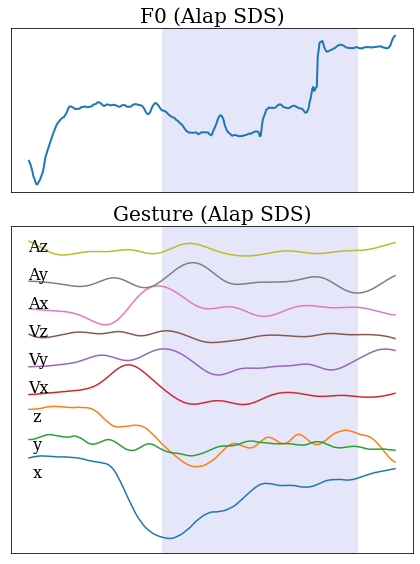

In [46]:
aalap1 = aalaps.loc[aalaps['filename']=='MP_Aalap1_Bag.csv']
segment = aalap1.loc[aalap1['time'].apply(lambda x: x > 106 and x < 110)]

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (6,8),sharex=True,gridspec_kw={'height_ratios': [1, 2]})

norm = 4
offset = 20
ax1.plot(segment['time'],segment['pitch'], linewidth=2)
ax2.plot(segment['time'],offset+segment['LWrist_x']*20)
ax2.plot(segment['time'],2*offset+segment['LWrist_y']*20)
ax2.plot(segment['time'],3*offset+segment['LWrist_z']*20)
ax2.plot(segment['time'],4*offset+segment['LWrist_vel_x']*5)
ax2.plot(segment['time'],5*offset+segment['LWrist_vel_y']*5)
ax2.plot(segment['time'],6*offset+segment['LWrist_vel_z']*5)
ax2.plot(segment['time'],7*offset+segment['LWrist_accl_x']*5)
ax2.plot(segment['time'],8*offset+segment['LWrist_accl_y']*5)
ax2.plot(segment['time'],9*offset+segment['LWrist_accl_z']*5)

ax1.axvspan(xmin = 107.46, xmax = 109.58, color = 'lavender')
ax2.axvspan(xmin = 107.46, xmax = 109.58, color = 'lavender')

textsize = 16
textcolor = 'black'
ax2.text(x = 106, y = offset, s = ' x', fontsize = textsize, color = textcolor)
ax2.text(x = 106, y = 2*offset, s = ' y', fontsize = textsize, color = textcolor)
ax2.text(x = 106, y = 3*offset, s = ' z', fontsize = textsize, color = textcolor)
ax2.text(x = 106, y = 4*offset, s = 'Vx', fontsize = textsize, color = textcolor)
ax2.text(x = 106, y = 5*offset, s = 'Vy', fontsize = textsize, color = textcolor)
ax2.text(x = 106, y = 6*offset, s = 'Vz', fontsize = textsize, color = textcolor)
ax2.text(x = 106, y = 7*offset, s = 'Ax', fontsize = textsize, color = textcolor)
ax2.text(x = 106, y = 8*offset, s = 'Ay', fontsize = textsize, color = textcolor)
ax2.text(x = 106, y = 9*offset, s = 'Az', fontsize = textsize, color = textcolor)

ax2.set_xticks([])
ax1.set_yticks([])
ax2.set_yticks([])
ax1.xaxis.set_tick_params(length=0)
ax1.set_title('F0 (Alap SDS)', fontsize = 20)
ax2.set_title('Gesture (Alap SDS)', fontsize = 20)

# ax2.legend(['x','y','z','Vx','Vy','Vz','Ax','Ay','Az'])

plt.tight_layout()

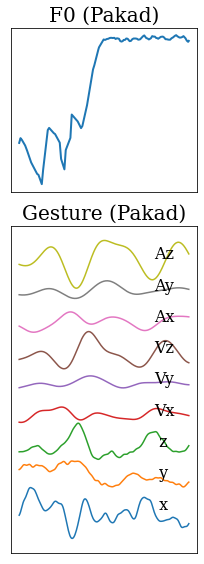

In [57]:
segment = pd.read_csv('./gmD_Queries/gmD_query_1.csv')

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (3,8),sharex=True,gridspec_kw={'height_ratios': [1, 2]})

norm = 2
offset = 20
ax1.plot(segment['time'],segment['pitch'], linewidth=2)
ax2.plot(segment['time'],1*offset+segment['LWrist_x']*20)
ax2.plot(segment['time'],2*offset+segment['LWrist_y']*20-20)
ax2.plot(segment['time'],3*offset+segment['LWrist_z']*10)
ax2.plot(segment['time'],4*offset+segment['LWrist_vel_x']*2)
ax2.plot(segment['time'],5*offset+segment['LWrist_vel_y']*2)
ax2.plot(segment['time'],6*offset+segment['LWrist_vel_z']*2)
ax2.plot(segment['time'],7*offset+segment['LWrist_accl_x']/2)
ax2.plot(segment['time'],8*offset+segment['LWrist_accl_y']/2)
ax2.plot(segment['time'],9*offset+segment['LWrist_accl_z']/2)

textsize = 16
x_text = 8.75
ax2.text(x = x_text, y = 20, s = ' x', fontsize = textsize)
ax2.text(x = x_text, y = 40 , s = ' y', fontsize = textsize)
ax2.text(x = x_text, y = 60, s = ' z', fontsize = textsize)
ax2.text(x = x_text, y = 80, s = 'Vx', fontsize = textsize)
ax2.text(x = x_text, y = 100, s = 'Vy', fontsize = textsize)
ax2.text(x = x_text, y = 120, s = 'Vz', fontsize = textsize)
ax2.text(x = x_text, y = 140, s = 'Ax', fontsize = textsize)
ax2.text(x = x_text, y = 160, s = 'Ay', fontsize = textsize)
ax2.text(x = x_text, y = 180, s = 'Az', fontsize = textsize)

ax2.set_xticks([])
ax1.set_yticks([])
ax2.set_yticks([])
ax1.xaxis.set_tick_params(length=0)
ax1.set_title('F0 (Pakad)', fontsize = 20)
ax2.set_title('Gesture (Pakad)', fontsize = 20)

# ax2.legend(['x','y','z','Vx','Vy','Vz','Ax','Ay','Az'], ncol = 3)

plt.tight_layout()

Text(0.5, 1.0, 'SDS with a Like instance of gmD')

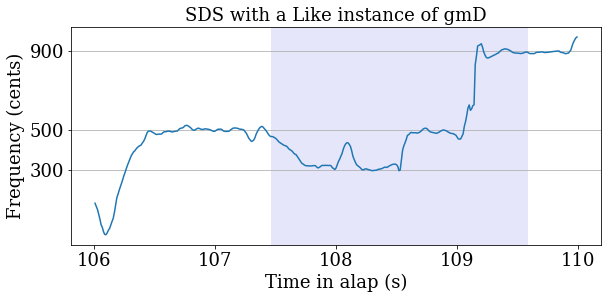

In [71]:
pitch = aalaps.loc[aalaps['filename']=='MP_Aalap1_Bag.csv'].reset_index(drop=True)
segment = pitch.loc[pitch['time'].apply(lambda x: x > 106 and x <110)]
gmd = pitch.loc[pitch['time'].apply(lambda x: x > 107.46 and x <109.58)]['pitch']

fig,axis = plt.subplots(1,1,figsize = (9.5,4))

axis.plot(segment['time'],segment['pitch'])
axis.axvspan(xmin = 107.46, xmax = 109.58, color = 'lavender')
axis.set_xticks([106, 107, 108,109,110],labels = [106,107,108,109,110], fontsize = 18)
axis.set_xlabel('Time in alap (s)', fontsize = 18)
axis.set_ylabel('Frequency (cents)', fontsize = 18);
axis.grid(axis= 'y')
axis.set_yticks([300,500,900], labels = [300,500,900], fontsize = 18);

# axis.text(x = 10775, y = 270, s='g',color = 'r',fontsize = 18)
# axis.text(x = 10850, y = 500, s='m',color = 'r',fontsize = 18)
# axis.text(x = 10950, y = 900, s='D',color = 'r',fontsize = 18)

axis.set_title('SDS with a Like instance of gmD', fontsize = 18)